In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

mushroom_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/agaricus-lepiota.data', header=None)

if mushroom_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mushroom_df.isna().sum().max()} NAs' )

MUSHROOM_NUMERICAL_COLS = ()
MUSHROOM_CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

mushroom_df.head()

Mounted at /content/gdrive/
There is no NA values


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [3]:
from future.utils import iteritems

class MushroomDataTransformer:
  def __init__(self, numerical_columns, categorical_columns):
    self.numerical_columns = numerical_columns
    self.categorical_columns = categorical_columns

  def fit(self, df):
    self.labelEncoders = {}
    self.scalers = {}
    for col in self.numerical_columns:
      scaler = StandardScaler()
      scaler.fit(df[col].reshape(-1, 1))
      self.scalers[col] = scaler

    for col in self.categorical_columns:
      encoder = LabelEncoder()
      # in case the train set does not have 'missing' value but test set does
      values = df[col].tolist()
      values.append('missing')
      encoder.fit(values)
      self.labelEncoders[col] = encoder

    # find dimensionality
    self.D = len(self.numerical_columns)
    for col, encoder in iteritems(self.labelEncoders):
      self.D += len(encoder.classes_)
    print("dimensionality:", self.D)

  def transform(self, df):
    N, _ = df.shape
    X = np.zeros((N, self.D))
    i = 0
    for col, scaler in iteritems(self.scalers):
      X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
      i += 1

    for col, encoder in iteritems(self.labelEncoders):
      # print "transforming col:", col
      K = len(encoder.classes_)
      X[np.arange(N), encoder.transform(df[col]) + i] = 1
      i += K
    return X

  def fit_transform(self, df):
    self.fit(df)
    return self.transform(df)

def replace_missing(df, numerical_columns, categorical_columns, special_missing_category='missing'):
  # standard method of replacement for numerical columns is median
  for col in numerical_columns:
    if np.any(df[col].isnull()):
      med = np.median(df[ col ][ df[col].notnull() ])
      df.loc[ df[col].isnull(), col ] = med

  # set a special value = 'missing'
  for col in categorical_columns:
    if np.any(df[col].isnull()):
      print(col)
      df.loc[ df[col].isnull(), col ] = special_missing_category

def get_mushroom_data(test_size=0.3):
  df = mushroom_df.copy()
  # replace label column: e/p --> 0/1, e = edible = 0, p = poisonous = 1
  df[0] = df.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)

  replace_missing(df, MUSHROOM_NUMERICAL_COLS, MUSHROOM_CATEGORICAL_COLS)
  transformer = MushroomDataTransformer(MUSHROOM_NUMERICAL_COLS, MUSHROOM_CATEGORICAL_COLS)

  X = df
  Y = df[0]
  if test_size > 0.0:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
  else:
    X_train, X_test, Y_train, Y_test = X, None, Y, None

  X_train_transformed = transformer.fit_transform(X_train)
  if X_test is not None:
    return X_train_transformed, transformer.transform(X_test), Y_train.values, Y_test.values
  else:
    return X_train_transformed, None, Y_train.values, None


# AdaBoost model class

In [4]:
def exponential_loss(p_hat, y):
  return np.exp(-y * p_hat).mean()

class AdaBoostClassifier:
  def __init__(self, base_model_factory, n_steps):
    self.base_model_factory = base_model_factory
    self.n_steps = n_steps
    self.base_models = []
    self.alphas = []

  def fit(self, X, Y):
    N = len(X)
    w = np.ones(N) / N
    
    for step in range(self.n_steps):
      f = self.base_model_factory()
      f.fit(X, Y, sample_weight=w)
      y_hat = f.predict(X)
      
      eps = w.dot(y_hat != Y) # / w.sum() # this is already normalized below
      alpha = 0.5 * (np.log(1-eps) - np.log(eps))
      w = w * np.exp(-alpha * Y * y_hat)
      w = w / np.sum(w) # normalize w
      
      self.alphas.append(alpha)
      self.base_models.append(f)
  
  def predict(self, X):
    return np.sign(self.predict_p(X))
      
  def predict_p(self, X):
    y_hat = np.zeros(len(X))
    for f, alpha in zip(self.base_models, self.alphas) :
      y_hat += alpha * f.predict(X)
    return y_hat

  def score(self, X, Y):
    f_hat = self.predict(X)
    return (f_hat == Y).mean()

  def score2(self, X, Y):
    f_hat = self.predict_p(X)
    score = (np.sign(f_hat) == Y).mean()
    loss = exponential_loss(f_hat, Y)
    return score, loss

# Use AdaBoost in mushroom data

dimensionality: 139
number of trees: 10
number of trees: 20
number of trees: 30
number of trees: 40
number of trees: 50
number of trees: 60
number of trees: 70
number of trees: 80
number of trees: 90
number of trees: 100
number of trees: 110
number of trees: 120
number of trees: 130
number of trees: 140
number of trees: 150
number of trees: 160
number of trees: 170
number of trees: 180
number of trees: 190
number of trees: 200


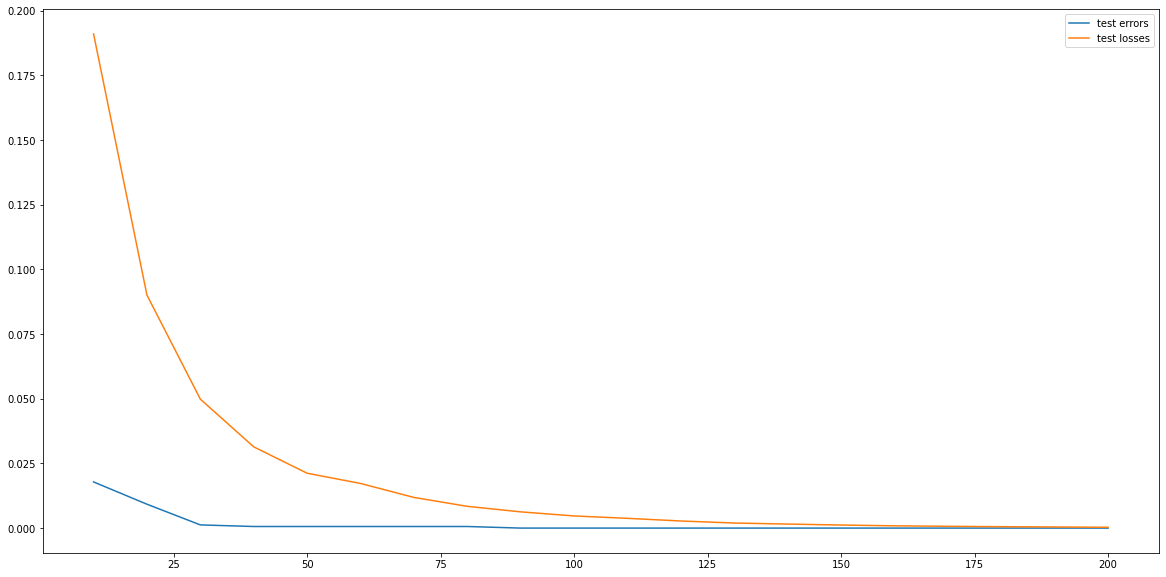

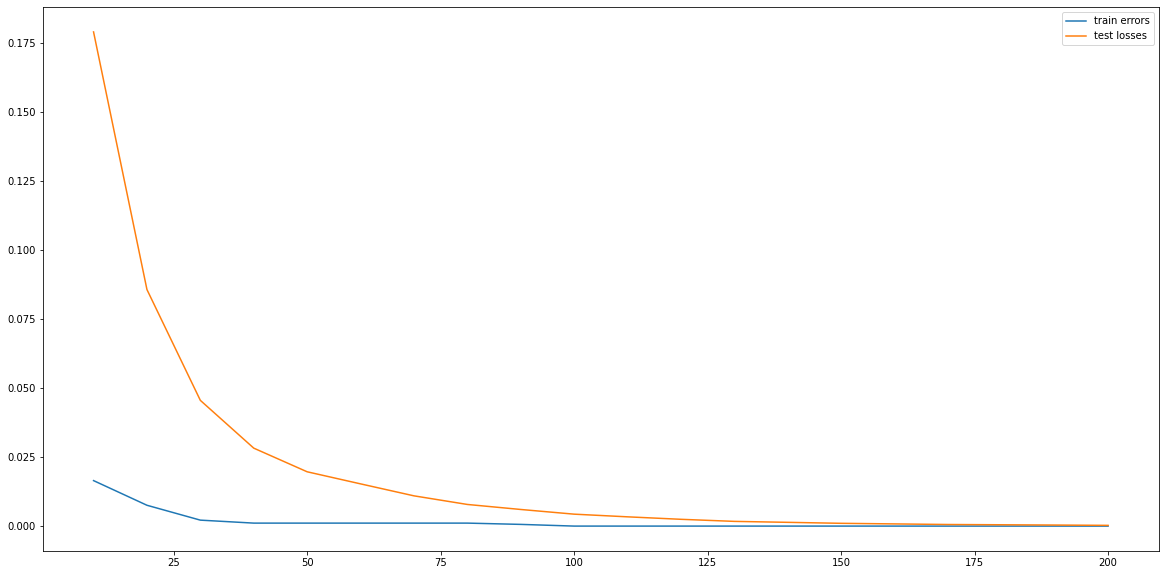

final train error: 0.0
final train loss: 0.0002622900737264428
final test error: 0.0
final testloss: 0.00031087690220486325


In [5]:
X_train, X_test, Y_train, Y_test = get_mushroom_data(test_size=0.2)
Y_train[Y_train == 0] = -1
Y_test[Y_test == 0] = -1

T = 200
T_step = 10

train_errors = []
test_errors = []
train_losses = []
test_losses = []
steps = []

for num_trees in range(0, T+1, T_step):
  if num_trees == 0:
    continue
  print('number of trees:', num_trees)

  model = AdaBoostClassifier(lambda : DecisionTreeClassifier(max_depth=1), n_steps=num_trees)
  model.fit(X_train, Y_train)
  acc, loss = model.score2(X_test, Y_test)
  acc_train, loss_train = model.score2(X_train, Y_train)
  train_errors.append(1 - acc_train)
  test_errors.append(1 - acc)
  train_losses.append(loss_train)
  test_losses.append(loss)
  steps.append(num_trees)

plt.figure(figsize=(20,10))
plt.plot(steps, test_errors, label='test errors')
plt.plot(steps, test_losses, label='test losses')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(steps, train_errors, label='train errors')
plt.plot(steps, train_losses, label='test losses')
plt.legend()
plt.show()

print("final train error:", 1 - acc_train)
print("final train loss:", loss_train)
print("final test error:", 1 - acc)
print("final testloss:", loss)